# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

---



First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)


[nltk_data] Downloading package brown to /home/a/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Total words in Brown corpus: 1161192


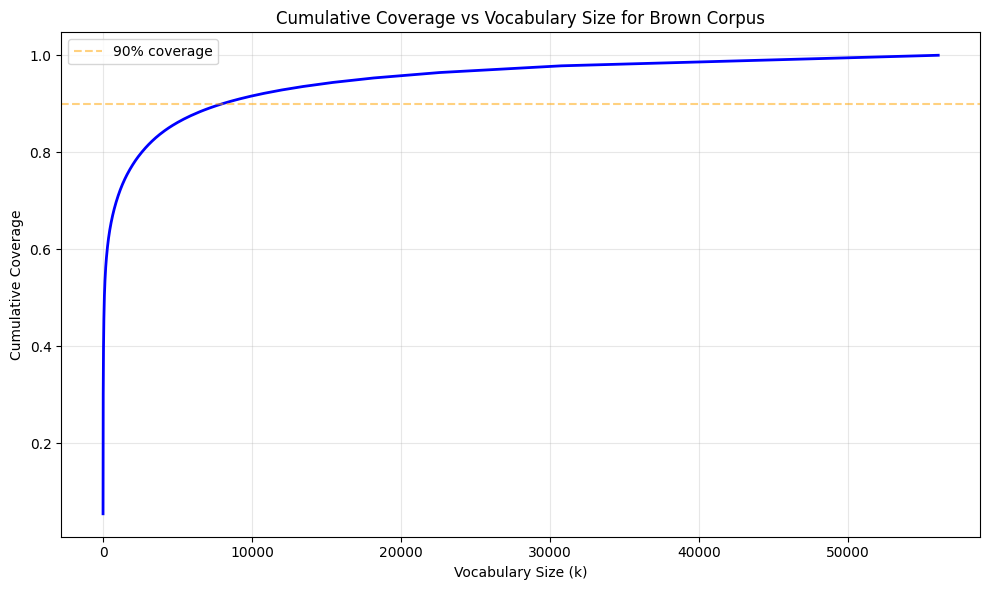


Vocabulary size (unique words): 56057
Words needed for 90% coverage: 8012


In [5]:
import nltk
from nltk.corpus import brown
from nltk import FreqDist
import matplotlib.pyplot as plt
import numpy as np

# Load the Brown Corpus
nltk.download('brown')

# Get all words from Brown corpus
words = brown.words()
print(f"Total words in Brown corpus: {len(words)}")

# Create frequency distribution
freq_dist = FreqDist(words)

# Get frequencies sorted by frequency
frequencies = sorted(freq_dist.values(), reverse=True)

# Calculate total number of tokens
total_tokens = sum(frequencies)

# Calculate cumulative coverage for each vocabulary size k
vocab_sizes = range(1, len(frequencies) + 1)
coverage = []

cumulative = 0
for k in vocab_sizes:
    cumulative += frequencies[k-1]
    coverage.append(cumulative / total_tokens)

# Plot cumulative coverage vs. vocabulary size
plt.figure(figsize=(10, 6))
plt.plot(vocab_sizes, coverage, 'b-', linewidth=2)
plt.xlabel('Vocabulary Size (k)')
plt.ylabel('Cumulative Coverage')
plt.title('Cumulative Coverage vs Vocabulary Size for Brown Corpus')
plt.grid(True, alpha=0.3)


plt.axhline(y=0.90, color='orange', linestyle='--', alpha=0.5, label='90% coverage')

plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nVocabulary size (unique words): {len(frequencies)}")
print(f"Words needed for 90% coverage: {np.argmax(np.array(coverage) >= 0.90) + 1}")

I select vocabulary size = 9000 Coverage = 90.87%

**4.**

*   As vocabulary size increases, each new word adds less coverage because its covering rarer and rarer words. This creates a diminishing return — early words cover a lot, but later ones add very little.
*   Zipf’s law — it states that the frequency of a word is inversely proportional to its rank, meaning most words are rare, so adding them yields diminishing coverage gains.\
$f(r) = \frac{C}{r^s}$

**Where**
- $f(r)$ is the frequency of the \( r \)-th most common word,
- $( C )$ is a constant,
- $ s \approx 1 $.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [ ]:
class BPETokenizer:
    """Byte-Pair Encoding (BPE) tokenizer.

    Implements the BPE algorithm as described in
    "Neural Machine Translation of Rare Words with Subword Units" (Sennrich et al., 2015).
    """

    def __init__(self, num_merges: int):
        """Initialize the tokenizer.

        Args:
            num_merges: Number of merge operations to learn during training.
        """
        self.num_merges = num_merges
        self.merges = []          # list of (left_symbol, right_symbol) in learned order
        self.vocab = set()         # set of all symbols (characters + merged subwords)

    def train(self, corpus):
        """Learn BPE merges from a text corpus.

        Args:
            corpus: List of strings (sentences) to learn the merges from.
        """
        # Build word frequency dictionary
        word_freq = {}
        for sentence in corpus:
            for word in sentence.split():
                word_freq[word] = word_freq.get(word, 0) + 1

        # Represent each word as list of characters
        word_to_symbols = {}
        for word in word_freq:
            word_to_symbols[word] = list(word) + ['</w>']

        # Initialize vocabulary with all characters
        for word in word_freq:
            for ch in word:
                self.vocab.add(ch)
        self.vocab.add('</w>')

        # Perform the desired number of merges
        for _ in range(self.num_merges):
            # Count frequencies of adjacent symbol pairs across all words
            pair_counts = {}
            for word, symbols in word_to_symbols.items():
                freq = word_freq[word]
                for i in range(len(symbols) - 1):
                    pair = (symbols[i], symbols[i + 1])
                    pair_counts[pair] = pair_counts.get(pair, 0) + freq

            if not pair_counts:
                break  # No more pairs to merge

            # Select the most frequent pair
            best_pair = max(pair_counts, key=pair_counts.get)
            self.merges.append(best_pair)

            # Merge this pair in every word representation
            merged_symbol = best_pair[0] + best_pair[1]
            for word, symbols in word_to_symbols.items():
                new_symbols = []
                i = 0
                while i < len(symbols):
                    if i < len(symbols) - 1 and symbols[i] == best_pair[0] and symbols[i + 1] == best_pair[1]:
                        new_symbols.append(merged_symbol)
                        i += 2
                    else:
                        new_symbols.append(symbols[i])
                        i += 1
                word_to_symbols[word] = new_symbols

            # Add the new merged symbol to the vocabulary
            self.vocab.add(merged_symbol)

    def tokenize(self, text):
        """Tokenize a text into subword units using the learned merges.

        Args:
            text: Input string (may contain multiple sentences).

        Returns:
            List of subword tokens (including end-of-word markers).
        """
        tokens = []
        for word in text.split():
            # Start with characters + end marker
            symbols = list(word) + ['</w>']

            # Apply merges in the order they were learned
            for left, right in self.merges:
                i = 0
                while i < len(symbols) - 1:
                    if symbols[i] == left and symbols[i + 1] == right:
                        symbols[i] = left + right   # merge into a single symbol
                        del symbols[i + 1]
                    else:
                        i += 1
            tokens.extend(symbols)

        return tokens

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [ ]:
import random
from tqdm import tqdm
DESIRED_VOCAB_SIZE = 9000

# Compute initial vocabulary size
all_chars = set()
for word in brown.words():
    all_chars.update(word)
initial_vocab_size = len(all_chars) + 1   

num_merges = DESIRED_VOCAB_SIZE - initial_vocab_size

sentences = [' '.join(sent) for sent in brown.sents()]

# Train tokenizer with the computed number of merges
tokenizer = BPETokenizer(num_merges=num_merges)
tokenizer.train(sentences)

# Now continue with evaluation
random.seed(42)
sample_sentences = random.sample(sentences, 1000)

fertilities = []
lengths = []

for sent in tqdm(sample_sentences, desc="Tokenizing samples"):
    original_words = sent.split()
    word_count = len(original_words)
    if word_count == 0:
        continue
    tokens = tokenizer.tokenize(sent)
    token_count = len(tokens)
    fertility = token_count / word_count
    fertilities.append(fertility)
    lengths.append(token_count)

mean_fertility = np.mean(fertilities)
std_fertility = np.std(fertilities)
mean_length = np.mean(lengths)
std_length = np.std(lengths)

print(f"Fertility (subword tokens per word): mean = {mean_fertility:.3f}, std = {std_fertility:.3f}")
print(f"Tokenized sentence length: mean = {mean_length:.1f}, std = {std_length:.1f}")

Vocabulary size after training: 9000
Number of merges actually performed: 8916


Tokenizing samples: 100%|██████████| 1000/1000 [00:18<00:00, 53.86it/s]

Fertility (subword tokens per word): mean = 1.245, std = 0.241
Tokenized sentence length: mean = 25.1, std = 17.9


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later.

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.